In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter
from scipy.stats import weibull_min, t
from scipy.optimize import curve_fit

1 GIFT_BASKET = 4 CHOCOLATE + 6 STRAWBERRIES + 1 ROSES

# Loading data

In [51]:
prices_1 = pd.read_csv('data/3/prices_round_3_day_0.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_2 = pd.read_csv('data/3/prices_round_3_day_1.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_3 = pd.read_csv('data/3/prices_round_3_day_2.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])

In [52]:
products = pd.read_csv('data/3/prices_round_3_day_0.csv', delimiter=';')['product'].unique()
products

array(['CHOCOLATE', 'STRAWBERRIES', 'ROSES', 'GIFT_BASKET'], dtype=object)

In [53]:
prices = {}
for product in products:
    prices[product] = []
    for day in range(3):
        df = pd.read_csv(f'data/3/prices_round_3_day_{day}.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
        df = df[df['product'] == product].set_index('timestamp', drop=True).drop(columns=['product'])
        prices[product].append(df)

In [54]:
trades = {}
for product in products:
    trades[product] = []
    for day in range(3):
        df = pd.read_csv(f'data/3/trades_round_3_day_{day}_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
        df = df[df['symbol'] == product].set_index('timestamp', drop=True).drop(columns=['symbol'])
        trades[product].append(df)

# Prices

In [55]:
products

array(['CHOCOLATE', 'STRAWBERRIES', 'ROSES', 'GIFT_BASKET'], dtype=object)

In [56]:
mids = pd.DataFrame()
for i in range(3):
    df = pd.DataFrame()
    for prod in products:
        df[prod] = prices[prod][i]['mid_price']
    mids = pd.concat([mids, df])
mids = mids.reset_index(drop=True)
mids.index = mids.index * 100

In [57]:
mids = mids.assign(GIFT_BASKET_EQ=lambda x: x.CHOCOLATE * 4 + x.STRAWBERRIES * 6 + x.ROSES)

In [58]:
mids.corr()

,CHOCOLATE,STRAWBERRIES,ROSES,GIFT_BASKET,GIFT_BASKET_EQ
CHOCOLATE,1.000000,0.273545,0.826358,0.947339,0.958706
STRAWBERRIES,0.273545,1.000000,0.148667,0.498003,0.494768
ROSES,0.826358,0.148667,1.000000,0.850830,0.856290
GIFT_BASKET,0.947339,0.498003,0.850830,1.000000,0.991897
GIFT_BASKET_EQ,0.958706,0.494768,0.856290,0.991897,1.000000


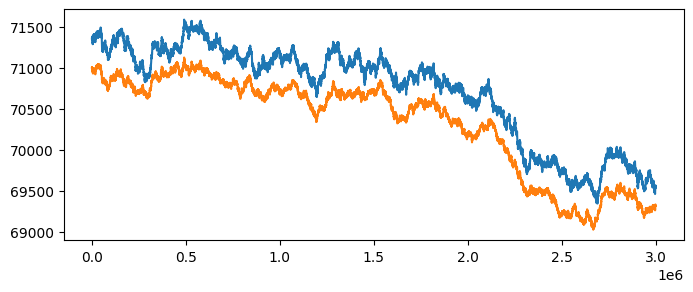

In [65]:
plt.figure(figsize=(8, 3))
plt.plot(mids['GIFT_BASKET'])
plt.plot(mids['GIFT_BASKET_EQ'])
plt.show()

In [49]:
# fig, ax = plt.subplots(4, 1, figsize=(12, 12))
# for i in range(4):
#     prod = products[i]
#     p1, p2, p3 = prices[prod]
#     ax[i].plot(p1.index, p1['mid_price'])
#     ax[i].plot(p1.index + p1.index[-1], p2['mid_price'])
#     ax[i].plot(p1.index + 2 * p1.index[-1], p3['mid_price'])
#     ax[i].set_ylabel(f'{prod} price')
#     ax[i].set_xlabel('timestamp')
# plt.show()

# Spread

In [10]:
print('{0:>19} {1:>7} {2:>7}'.format('Mean', 'Min', 'Max'))
print('-'*37)
for prod in products:
    p1 = prices[prod][0]
    orderflow_imbalance = p1['bid_volume_1'].fillna(0) + p1['bid_volume_2'].fillna(0) + p1['bid_volume_3'].fillna(0) -\
        p1['ask_volume_1'].fillna(0) - p1['ask_volume_2'].fillna(0) - p1['ask_volume_3'].fillna(0)
    print(f'{prod:>12}| {orderflow_imbalance.mean():<8} {orderflow_imbalance.min():<8} {orderflow_imbalance.max():<8}')

               Mean     Min     Max
-------------------------------------
   CHOCOLATE| 0.007    -10.0    10.0    
STRAWBERRIES| 0.0035   -12.0    12.0    
       ROSES| 0.0042   -11.0    11.0    
 GIFT_BASKET| -0.03    -38.0    30.0    


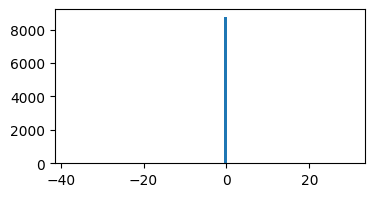

In [11]:
p1 = prices['GIFT_BASKET'][0]

orderflow_imbalance = p1['bid_volume_1'].fillna(0) + p1['bid_volume_2'].fillna(0) + p1['bid_volume_3'].fillna(0) -\
p1['ask_volume_1'].fillna(0) - p1['ask_volume_2'].fillna(0) - p1['ask_volume_3'].fillna(0)

plt.figure(figsize=(4, 2))
plt.hist(orderflow_imbalance, 100)
plt.show()

# True and Equivalent GIFT_BASKET

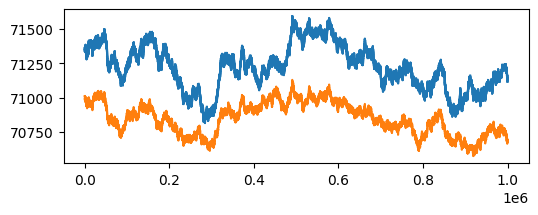

In [25]:
mid = prices['GIFT_BASKET'][0]['mid_price']
bid1 = prices['GIFT_BASKET'][0]['bid_price_1']
bid2 = prices['GIFT_BASKET'][0]['bid_price_2']
bid3 = prices['GIFT_BASKET'][0]['bid_price_3']
ask1 = prices['GIFT_BASKET'][0]['ask_price_1']
ask2 = prices['GIFT_BASKET'][0]['ask_price_2']
ask3 = prices['GIFT_BASKET'][0]['ask_price_3']

mid_eq = 4 * prices['CHOCOLATE'][0]['mid_price'] + 6 * prices['STRAWBERRIES'][0]['mid_price'] + prices['ROSES'][0]['mid_price']
bid1_eq = 4 * prices['CHOCOLATE'][0]['bid_price_1'] + 6 * prices['STRAWBERRIES'][0]['bid_price_1'] + prices['ROSES'][0]['bid_price_1']
bid2_eq = 4 * prices['CHOCOLATE'][0]['bid_price_2'] + 6 * prices['STRAWBERRIES'][0]['bid_price_2'] + prices['ROSES'][0]['bid_price_2']
bid3_eq = 4 * prices['CHOCOLATE'][0]['bid_price_3'] + 6 * prices['STRAWBERRIES'][0]['bid_price_3'] + prices['ROSES'][0]['bid_price_3']
ask1_eq = 4 * prices['CHOCOLATE'][0]['ask_price_1'] + 6 * prices['STRAWBERRIES'][0]['ask_price_1'] + prices['ROSES'][0]['ask_price_1']
ask2_eq = 4 * prices['CHOCOLATE'][0]['ask_price_2'] + 6 * prices['STRAWBERRIES'][0]['ask_price_2'] + prices['ROSES'][0]['ask_price_2']
ask3_eq = 4 * prices['CHOCOLATE'][0]['ask_price_3'] + 6 * prices['STRAWBERRIES'][0]['ask_price_3'] + prices['ROSES'][0]['ask_price_3']

plt.figure(figsize=(6, 2))
plt.plot(bid1, c='tab:blue')
plt.plot(bid2, c='tab:blue')
plt.plot(bid3, c='tab:blue')
plt.plot(ask1, c='tab:blue')
plt.plot(ask2, c='tab:blue')
plt.plot(ask3, c='tab:blue')
plt.plot(bid1_eq, c='tab:orange')
plt.plot(bid2_eq, c='tab:orange')
plt.plot(bid3_eq, c='tab:orange')
plt.plot(ask1_eq, c='tab:orange')
plt.plot(ask2_eq, c='tab:orange')
plt.plot(ask3_eq, c='tab:orange')
plt.show()

In [44]:
mids = pd.concat([mid, mid_eq], axis=1)
mids.columns=['GIFT_BASKET', 'COMPOSIT']
mids.corr()

,GIFT_BASKET,COMPOSIT
GIFT_BASKET,1.00000,0.97902
COMPOSIT,0.97902,1.00000


In [26]:
dif = []
for i in range(3):
    mid = prices['GIFT_BASKET'][i]['mid_price']
    mid_eq = 4 * prices['CHOCOLATE'][i]['mid_price'] + 6 * prices['STRAWBERRIES'][i]['mid_price'] + prices['ROSES'][i]['mid_price']
    dif.append(mid - mid_eq)
dif = pd.concat(dif).reset_index(drop=True)
dif.index = dif.index * 100

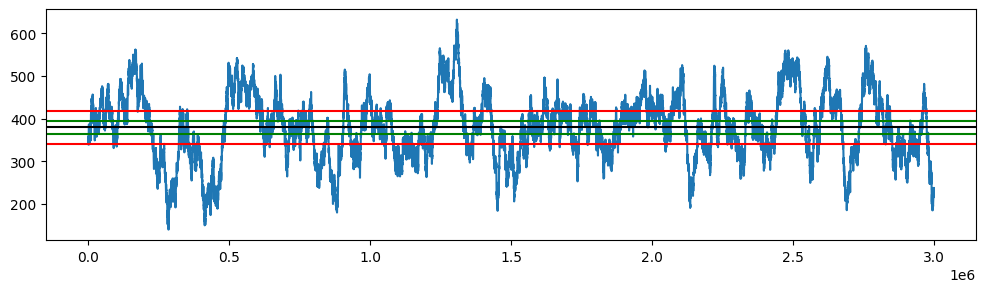

In [31]:
plt.figure(figsize=(12, 3))
plt.plot(dif)
plt.axhline(dif.mean(), c='k')
plt.axhline(dif.mean() + 0.2 * dif.std(), c='g')
plt.axhline(dif.mean() - 0.2 * dif.std(), c='g')
plt.axhline(dif.mean() + 0.5 * dif.std(), c='r')
plt.axhline(dif.mean() - 0.5 * dif.std(), c='r')
plt.show()

In [29]:
print(f'Mean spread: {dif.mean()} -- STD spread: {dif.std()}')

Mean spread: 379.4904833333333 -- STD spread: 76.42438217375009


370.2306
381.9418
386.29905


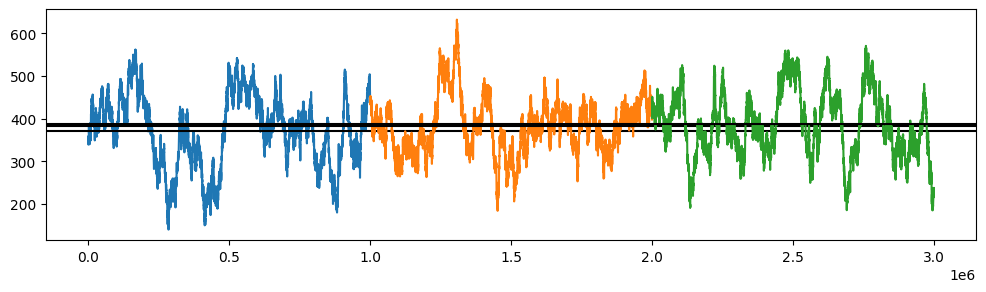

In [16]:
plt.figure(figsize=(12, 3))
for i in range(3):
    mid = prices['GIFT_BASKET'][i]['mid_price']
    mid_eq = 4 * prices['CHOCOLATE'][i]['mid_price'] + 6 * prices['STRAWBERRIES'][i]['mid_price'] + prices['ROSES'][i]['mid_price']
    dif =  mid - mid_eq
    plt.plot(dif.index + i * dif.index[-1], dif)
    plt.axhline(dif.mean(), c='k')
    print(dif.mean())
plt.show()

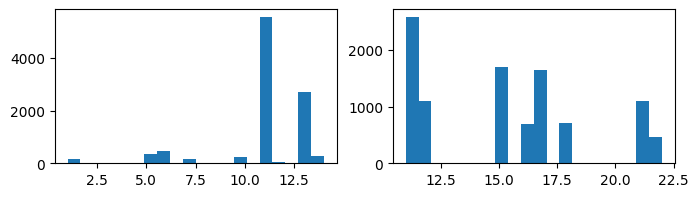

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].hist(ask1 - bid1, bins=20)
ax[1].hist(ask1_eq - bid1_eq, bins=20)
plt.show()

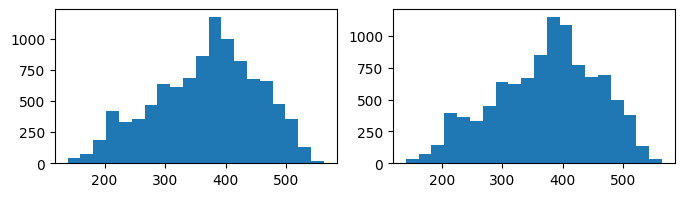

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].hist(ask1 - ask1_eq, bins=20)
ax[1].hist(bid1 - bid1_eq, bins=20)
plt.show()

In [20]:
(ask1 - ask1_eq).mean(), (bid1 - bid1_eq).mean()

(368.0815, 372.3797)